In [190]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style('whitegrid')
sns.set_palette('deep')

In [ ]:
# Load NYT data
df = pd.read_csv(
    "https://raw.githubusercontent.com/nytimes/covid-19-data/master/us-counties.csv"
)
df.set_index(['state','county'],inplace=True)

In [59]:
# Load county population data
state_ref = pd.read_csv('./co-est2019-alldata.csv')
state_ref['fips'] = state_ref['STATE'].apply(lambda x: str(x)) + state_ref['COUNTY'].apply(lambda x: str(x).zfill(3))
state_ref['fips'] = state_ref['fips'].astype('int')
county_pop = state_ref[['fips','CTYNAME','POPESTIMATE2019']]

In [ ]:
included_counties = [
    ['Minnesota',  'Hennepin'  ],
    ['Washington', 'King'      ],
    ['Montana',    'Gallatin'  ],
    ['Illinois',   'Cook'      ],
    ['Wisconsin',  'Door'      ],
    ['Florida',    'Walton'    ],
    ['Illinois',   'Champaign' ],
    ['Arizona',    'Pima'      ],
    ['Connecticut','New Haven' ]
]

l = [df.loc[x[0],x[1]] for x in included_counties]
df_sub = pd.concat(l)

df_sub['date'] = pd.to_datetime(df_sub['date'])

# calculate new daily cases and combine with population data
df_sub_pop = df_sub.reset_index().groupby(
    ['date','fips']
)['cases'].sum().unstack(
    'fips'
).diff().stack(
    'fips'
).rename('cases').reset_index().merge(
    county_pop,
    how='left',
    on='fips'
)

# calculate rate per 100,000 people
df_sub_pop['case_rate'] = df_sub_pop['cases'] / (df_sub_pop['POPESTIMATE2019']/100000)
# convert to 7-day average
df_case_rate_avg = df_sub_pop.reset_index().groupby(
    ['date','CTYNAME']
)['case_rate'].sum().unstack('CTYNAME').rolling(window=7).mean()


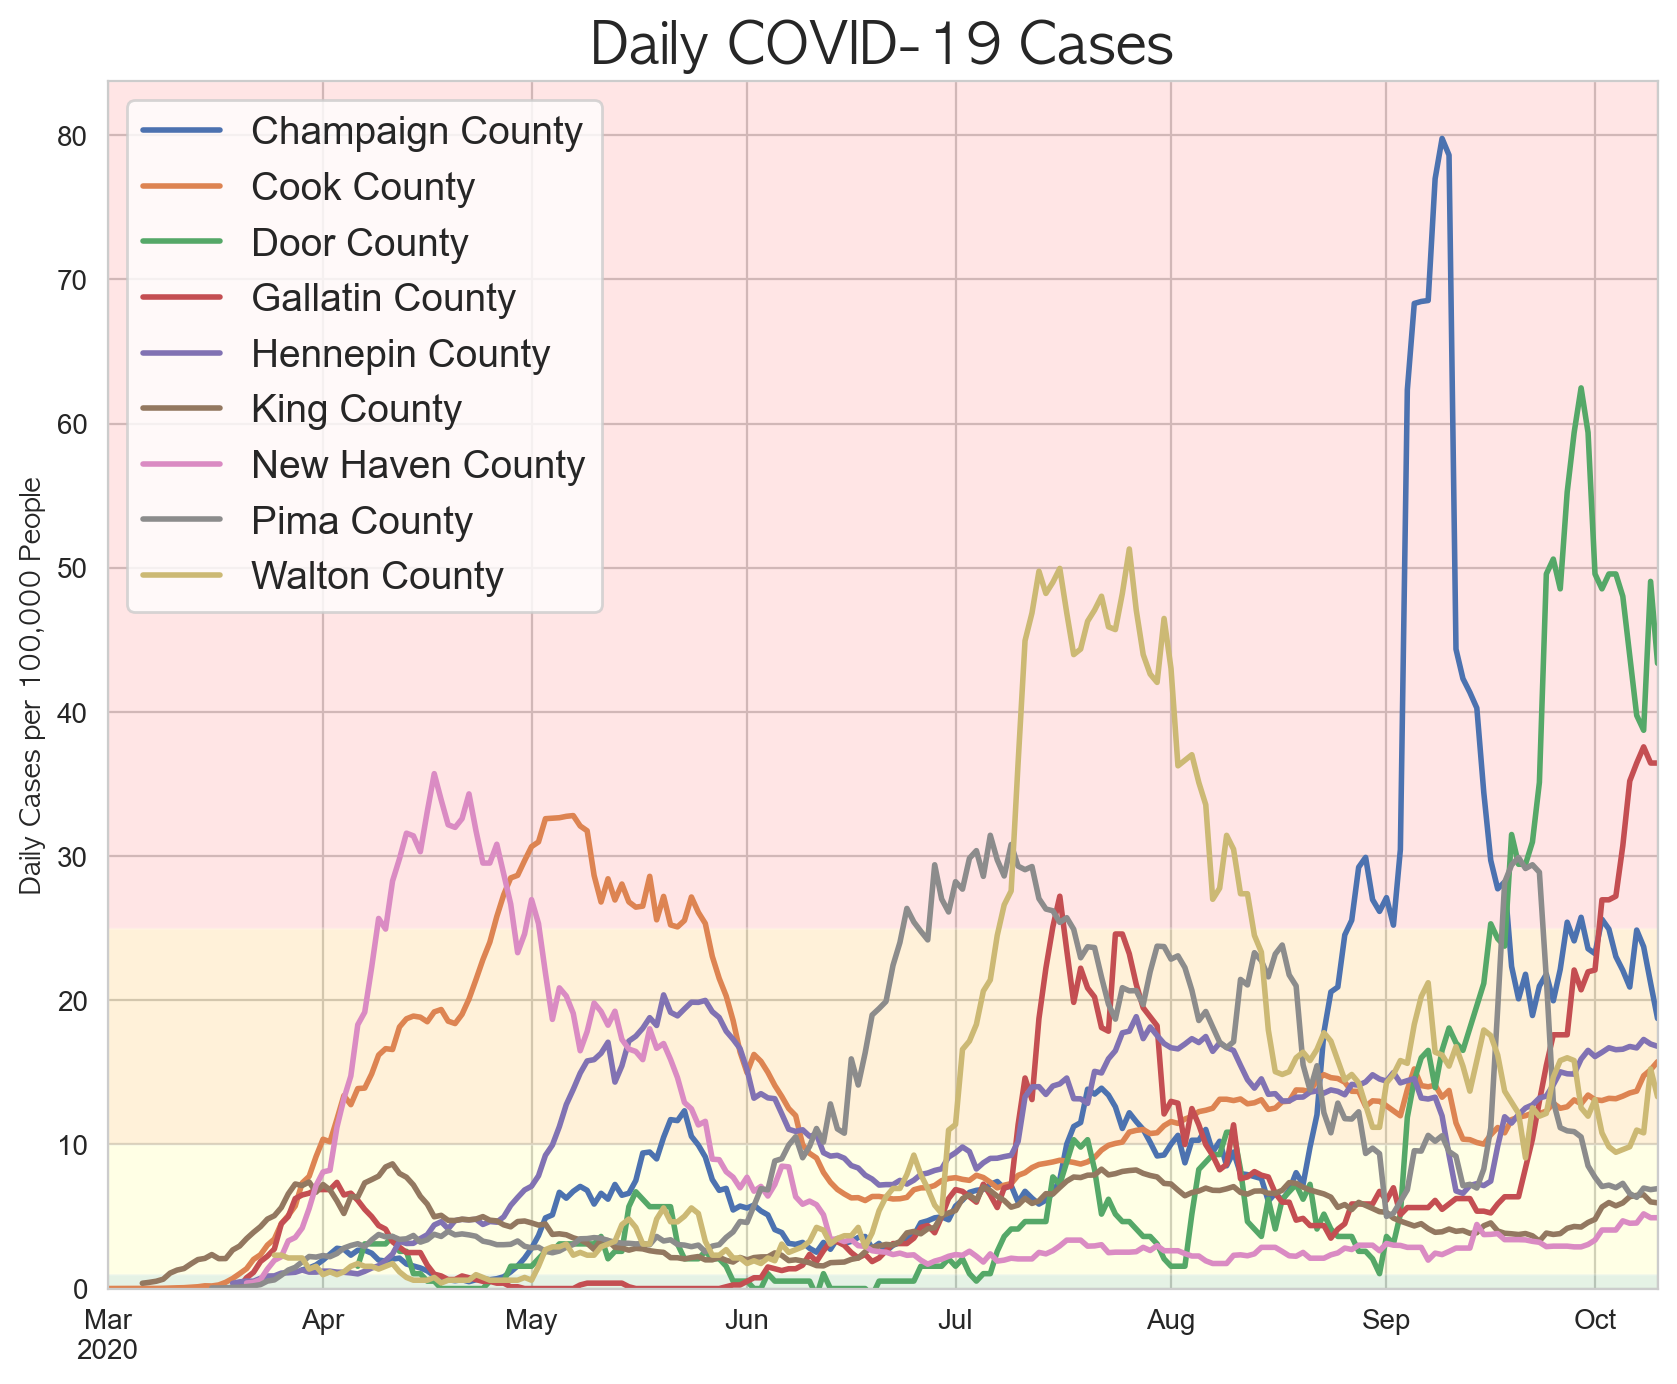

In [202]:
# set up figure
fig, ax1 = plt.subplots(
    figsize=(10,8),
    dpi=200
)

# plot the data (March onwards)
df_case_rate_avg.loc['2020-03-01':].plot(
    ax=ax1,
    linewidth=2
)

# styling
font = 'AppleGothic'
ax1.set_ylabel(
    "Daily Cases per 100,000 People",
    fontname=font
)
ax1.set_title(
    "Daily COVID-19 Cases",
    fontname=font,
    size=20
)
ax1.set_xlabel("")
ax1.set_ylim(0)
ax1.legend(
    title="",
    prop={'weight':'normal',
         'size':14},

)

# add color categories
ax1.fill_between(
    df_case_rate_avg.loc['2020-03-01':].index,
    [0]*len(df_case_rate_avg.loc['2020-03-01':]),
    [1]*len(df_case_rate_avg.loc['2020-03-01':]),
    facecolor='green',
    alpha=0.1
)

ax1.fill_between(
    df_case_rate_avg.loc['2020-03-01':].index,
    1,
    10,
    facecolor='yellow',
    alpha=0.1
)
ax1.fill_between(
    df_case_rate_avg.loc['2020-03-01':].index,
    10,
    25,
    facecolor='orange',
    alpha=0.15
)
ax1.fill_between(
    df_case_rate_avg.loc['2020-03-01':].index,
    25,
    ax1.get_ylim()[1],
    facecolor='red',
    alpha=0.1
)

# TODO: need to incorporate data attributions and citations

plt.show()